<a href="https://colab.research.google.com/github/Jungkihong07/Deepwave/blob/main/dnn_baseline_kh_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset class 선언

In [ ]:
import os
import librosa
import torch
from torch.utils.data import Dataset
import numpy as np
from sklearn.preprocessing import StandardScaler

class AutoCachedMFCCDataset(Dataset):
    def __init__(self, label_path, audio_dir, cache_path=None, scaler=None, n_mfcc=13):
        """
        label_path: train/test_label.txt
        audio_dir: wav 파일이 있는 폴더 경로
        cache_path: 캐시 파일 경로 (.npz)
        scaler: train용 정규화 스케일러 (test에서는 동일하게 사용)
        """
        self.X = None
        self.y = None

        if cache_path and os.path.exists(cache_path):
            # ✅ 캐시 로딩
            data = np.load(cache_path)
            self.X = data['X']
            self.y = data['y']

            if 'mean' in data and 'scale' in data:
                self.scaler = StandardScaler()
                self.scaler.mean_ = data['mean']
                self.scaler.scale_ = data['scale']
                self.X = self.scaler.transform(self.X)
            elif scaler is not None:
                self.scaler = scaler
                self.X = self.scaler.transform(self.X)
            else:
                self.scaler = None
        else:
            # 🔧 캐시 없을 경우: librosa로 로드 & MFCC 추출
            self.samples = []
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        speaker_id = parts[0]
                        filename = parts[1]
                        label_str = parts[-1]
                        label = 1 if label_str.lower() == 'real' else 0
                        self.samples.append((filename, label, speaker_id))

            mfcc_features = []
            for fname, label, _ in self.samples:
                path = os.path.join(audio_dir, fname)
                try:
                    # 1차 시도
                    # y, sr = librosa.load(path, sr=16000)
                    # mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
                    # mfcc_mean = np.mean(mfcc, axis=1)

                    # 2차 시도 (개선된 특징 추출)
                    # MFCC + delta MFCC 특징 추출 부분 (입력 차원: 26)
                    y, sr = librosa.load(path, sr=16000)
                    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)                # (13, T)
                    delta = librosa.feature.delta(mfcc)                                   # (13, T)
                    mfcc_combined = np.concatenate([mfcc, delta], axis=0)                # (26, T)
                    mfcc_mean = np.mean(mfcc_combined, axis=1)                           # (26,)
                except Exception as e:
                    print(f"[Error] {fname}: {e}")
                    mfcc_mean = np.zeros(n_mfcc)
                mfcc_features.append(mfcc_mean)

            self.X = np.array(mfcc_features)
            self.y = np.array([label for _, label, _ in self.samples])

            if scaler is None:
                self.scaler = StandardScaler()
                self.X = self.scaler.fit_transform(self.X)
            else:
                self.scaler = scaler
                self.X = self.scaler.transform(self.X)

            # ✅ 캐시 저장
            if cache_path:
                np.savez(cache_path, X=self.X, y=self.y,
                         mean=self.scaler.mean_, scale=self.scaler.scale_)
                print(f"✔️ 캐시 저장 완료: {cache_path}")

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.long)
        return x, y

# 2. 학습 및 테스트  셋 따로 로딩.

In [ ]:
# 🔹 경로 지정
train_label_path = '/content/drive/MyDrive/기계학습(Deepwave)/데이터 셋/2501ml_data/label/train_label.txt'
train_audio_dir = '/content/drive/MyDrive/기계학습(Deepwave)/데이터 셋/2501ml_data/train'
train_cache = '/content/drive/MyDrive/기계학습(Deepwave)/캐시/train_mfcc.npz'

test_label_path = '/content/drive/MyDrive/기계학습(Deepwave)/데이터 셋/2501ml_data/label/test_label.txt'
test_audio_dir = '/content/drive/MyDrive/기계학습(Deepwave)/데이터 셋/2501ml_data/test'
test_cache = '/content/drive/MyDrive/기계학습(Deepwave)/캐시/test_mfcc.npz'

# 학습셋: 캐시 없으면 자동 생성
train_dataset = AutoCachedMFCCDataset(
    train_label_path, train_audio_dir, cache_path=train_cache
)

# 테스트셋: train 스케일러 공유
test_dataset = AutoCachedMFCCDataset(
    test_label_path, test_audio_dir, cache_path=test_cache, scaler=train_dataset.scaler
)
from torch.utils.data import DataLoader
# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# 추후 연구를 위한 캐시 저장

In [ ]:
# 저장 경로 설정
save_dir = '/content/drive/MyDrive/기계학습(Deepwave)/캐시'
os.makedirs(save_dir, exist_ok=True)

# 저장 파일명 설정
train_save_path = os.path.join(save_dir, 'train_mfcc.npz')
test_save_path = os.path.join(save_dir, 'test_mfcc.npz')

# train 데이터 저장
np.savez(train_save_path, X=train_dataset.X, y=train_dataset.y,
         mean=train_dataset.scaler.mean_, scale=train_dataset.scaler.scale_)

# test 데이터 저장
np.savez(test_save_path, X=test_dataset.X, y=test_dataset.y)

print(f"✅ 저장 완료!\n- Train: {train_save_path}\n- Test:  {test_save_path}")


✅ 저장 완료!
- Train: /content/drive/MyDrive/기계학습(Deepwave)/캐시/train_mfcc.npz
- Test:  /content/drive/MyDrive/기계학습(Deepwave)/캐시/test_mfcc.npz


# Train set 중에서 train/val 부분 나눔.
- 실제 보지 못한 데이터에는 성능이 떨어지는 **과적합(overfitting)**을 방지하기 위해,
전체 학습 데이터 중 일부를 **검증용(validation set)**으로 분리하여 학습 도중 성능을 확인 위함.

- 이렇게 하면 매 epoch마다 **모델의 일반화 성능을 추적** 가능.
   - 학습 조기 종료 (early stopping),
   - 최적 모델 선택,
   - 하이퍼파라미터 조정

In [ ]:
from torch.utils.data import Subset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

# 🔹 train_dataset은 AutoCachedMFCCDataset으로 로딩된 상태여야 함

# 🔸 stratify 분할을 위해 y값 추출
y_labels = train_dataset.y if isinstance(train_dataset, AutoCachedMFCCDataset) else np.array([train_dataset[i][1].item() for i in range(len(train_dataset))])

# 🔸 인덱스 생성 및 분할
train_idx, val_idx = train_test_split(
    np.arange(len(train_dataset)),
    test_size=0.2,
    stratify=y_labels,
    random_state=42
)

# 전체 학습 데이터에서 80%는 train, 20%는 validation으로 분할합니다.
# → 검증 셋을 통해 학습 중 과적합 여부를 확인하기 위함입니다.

# 🔸 PyTorch Subset으로 분리
train_subset = Subset(train_dataset, train_idx)
val_subset = Subset(train_dataset, val_idx)

# 🔸 DataLoader 구성
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32)

print(f"📦 학습 샘플 수: {len(train_loader.dataset)}")
print(f"📦 검증 샘플 수: {len(val_loader.dataset)}")

📦 학습 샘플 수: 3200
📦 검증 샘플 수: 800


# DNN 모델 정의(Pytorch)

## DNN 모델 ver1.


### 모델 구성
#### ✅ 입력 크기
- 입력은 13차원의 MFCC 평균 벡터로, 입력층은 `input_dim=13`으로 고정된다.

#### ✅ 은닉층 구조
- `1번째 은닉층: 64 units`  
  → 13차원의 입력을 더 풍부한 표현 공간으로 확장하여, 복잡한 패턴 학습 가능.
- `2번째 은닉층: 32 units`  
  → 점진적인 차원 축소를 통해 중요한 특징만 추출.
- `3번째 은닉층: 16 units`  
  → 최종 분류에 앞서 노이즈를 줄이고 정제된 정보만 전달.
- 각 층마다 **ReLU 활성화 함수**를 사용하여 비선형성을 부여하고, 학습 효율을 높였다.

#### ✅ 출력층
- 출력층은 `2개 노드`로 구성되며, CrossEntropyLoss를 사용하기 때문에 **softmax는 따로 적용하지 않음**.
- 출력 결과는 `[Fake 확률, Real 확률]` 형태의 로짓 벡터로 나타난다.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class MFCCClassifier(nn.Module):
    def __init__(self):
        super(MFCCClassifier, self).__init__()

        self.fc1 = nn.Linear(13, 64)     # 입력 → 은닉층1
        self.fc2 = nn.Linear(64, 32)     # 은닉층1 → 은닉층2
        self.fc3 = nn.Linear(32, 16)     # 은닉층2 → 은닉층3
        self.fc4 = nn.Linear(16, 2)      # 은닉층3 → 출력층 (Real/Fake)

    def forward(self, x):
        x = F.relu(self.fc1(x))          # 비선형 활성화 함수: ReLU
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)               # 로짓(logits) 출력 (CrossEntropyLoss용)

#### 🧪 실험 결과 요약

### ✅ 모델 구조
- 입력: 13차원 MFCC 평균 벡터
- 은닉층: [64 → 32 → 16], 각 층 ReLU 활성화
- 출력층: 2개 노드 (Real / Fake)
- 손실 함수: CrossEntropyLoss
- 최적화: Adam (lr=0.001)
- Epoch 수: 20
- Batch size: 32

---

### ✅ 데이터 구성
- 학습 데이터: 4,000개 (Real 2,000 / Fake 2,000)
- 테스트 데이터: 2,000개 (Real 1,000 / Fake 1,000)
- 학습 데이터의 20%는 검증용으로 분할

---

### ✅ 성능 결과

| 지표 | Fake | Real | 전체 평균 |
|------|------|------|------------|
| Precision | 0.48 | 0.49 | 0.49 |
| Recall    | 0.34 | 0.64 | 0.49 |
| F1-score  | 0.40 | 0.55 | 0.48 |
| Accuracy  | -    | -    | **0.49** |

- Fake 클래스의 **recall이 매우 낮음** → Fake 음성 탐지 실패가 많음
- 전체 정확도는 **49%로 랜덤 분류 수준**

---

### ✅ Confusion Matrix (TEST)

| 실제\예측 | Fake | Real |
|-----------|------|------|
| Fake      | 342  | 658  |
| Real      | 364  | 636  |

→ Fake를 Real로 잘못 분류한 경우가 많았음 (658건)

---

### ✅ 결론 및 개선 필요 사항

- 모델이 **Real을 기준으로 분류하는 경향**이 있으며, Fake 탐지가 취약함
- 간단한 DNN 구조로는 충분한 분류 성능 확보가 어려움
- 다음 실험에서는 다음 전략을 적용할 예정:
  - Dropout 및 BatchNorm 추가
  - ΔMFCC, Mel Spectrogram 등 특징 확장

### ✅ 원인 분석
- 특징 표현 부족 (단순 MFCC 평균)
- 모델 용량 부족 (얕은 구조)
- 과적합 가능성 (train acc 높고 test 낮다면)
- 모델 일반화 능력 부족

## DNN 모델 ver2.


### 모델 구성


### ✅ 입력 크기
- 입력은 MFCC(13차원)와 ΔMFCC(13차원)를 결합한 총 **26차원**의 평균 벡터로, 입력층은 `input_dim=26`로 고정된다.


### ✅ 은닉층 구조

- **1번째 은닉층: 128 units + BatchNorm + Dropout(0.3)**  
  → 고차원의 표현 공간으로 확장하여 더 복잡한 음성 특징을 학습할 수 있도록 한다.  
  → Batch Normalization을 통해 학습 안정성과 수렴 속도를 향상시킨다.  
  → Dropout은 과적합 방지를 위해 적용한다.

- **2번째 은닉층: 64 units + BatchNorm + Dropout(0.3)**  
  → 중요 특징만 남기기 위한 차원 축소 역할을 수행하며, 동일한 정규화 및 Dropout 적용.

- **3번째 은닉층: 32 units + BatchNorm + Dropout(0.3)**  
  → 최종 분류 직전에 정보를 정제하고, 불필요한 특징을 제거한다.

---

### ✅ 출력층
손실 함수로는 `CrossEntropyLoss`를 사용하기 때문에, 별도로 softmax는 적용하지 않는다.  

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class MFCCClassifier(nn.Module):
    def __init__(self):
        super(MFCCClassifier, self).__init__()

        self.fc1 = nn.Linear(26, 128)  # 입력 차원 변경됨 (13 → 26)
        self.bn1 = nn.BatchNorm1d(128)
        self.drop1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.drop2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.drop3 = nn.Dropout(0.3)

        self.fc4 = nn.Linear(32, 2)  # Real / Fake

    def forward(self, x):
        x = self.drop1(F.relu(self.bn1(self.fc1(x))))
        x = self.drop2(F.relu(self.bn2(self.fc2(x))))
        x = self.drop3(F.relu(self.bn3(self.fc3(x))))
        return self.fc4(x)

# 2. 모델 학습 루프 ( Train + validation)

In [ ]:
import torch

# 디바이스 설정 (GPU 사용 가능하면 GPU 사용)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Using device: {device}")

# 모델, 손실 함수, 옵티마이저 정의
model = MFCCClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 학습 설정
num_epochs = 20

# 학습 루프 시작
for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0
    train_correct = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = outputs.argmax(dim=1)
        train_correct += (preds == y).sum().item()

    train_acc = train_correct / len(train_loader.dataset)

    # 🔹 검증 단계 (val_loader가 있는 경우)
    val_acc = 0
    if 'val_loader' in globals():
        model.eval()
        val_correct = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                preds = outputs.argmax(dim=1)
                val_correct += (preds == y).sum().item()
        val_acc = val_correct / len(val_loader.dataset)
        print(f"[Epoch {epoch:02d}] Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%")
    else:
        print(f"[Epoch {epoch:02d}] Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")

🖥️ Using device: cuda


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x13 and 26x128)

In [ ]:
model.eval()  # 평가 모드로 전환
test_correct = 0
predictions = []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        preds = outputs.argmax(dim=1)
        test_correct += (preds == y).sum().item()
        predictions.extend(preds.cpu().numpy())  # 전체 예측 결과 저장

test_acc = test_correct / len(test_loader.dataset)
print(f"🎯 Test Accuracy: {test_acc * 100:.2f}%")


🎯 Test Accuracy: 55.95%



✅ [TEST 평가 결과]
              precision    recall  f1-score   support

        Fake       0.59      0.39      0.47      1000
        Real       0.54      0.73      0.62      1000

    accuracy                           0.56      2000
   macro avg       0.57      0.56      0.55      2000
weighted avg       0.57      0.56      0.55      2000



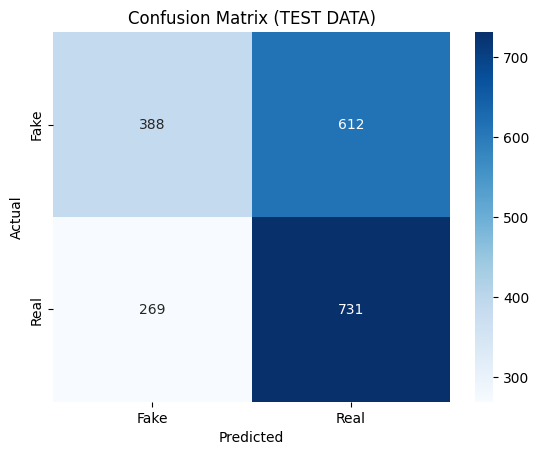

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 🔹 예측 결과 및 정답 수집
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        outputs = model(x)
        preds = outputs.argmax(dim=1).cpu().numpy()    # 예측값
        labels = y.numpy()                             # 실제값

        all_preds.extend(preds)
        all_labels.extend(labels)

# 🔹 Classification Report
print("\n✅ [TEST 평가 결과]")
print(classification_report(all_labels, all_preds, target_names=['Fake', 'Real']))

# 🔹 Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (TEST DATA)")
plt.show()